# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [7]:
import sys
sys.path.insert(0, "monodepth2/")

In [8]:
# from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import monodepth2.networks as networks
from monodepth2.utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [9]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

/mnt/nvme0n1p5/SRINUX/ucu_courses/3_year/2_semester/ml/SLAM/chaika/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/mnt/nvme0n1p5/SRINUX/ucu_courses/3_year/2_semester/ml/SLAM/chaika/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Loading the test image and preprocessing

In [10]:
image_path = "masinka.png"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [13]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
print(disp, torch.min(disp), torch.max(disp))

tensor([[[[0.2412, 0.2418, 0.2409,  ..., 0.1549, 0.1536, 0.1541],
          [0.2417, 0.2424, 0.2418,  ..., 0.1558, 0.1544, 0.1546],
          [0.2409, 0.2416, 0.2408,  ..., 0.1539, 0.1526, 0.1529],
          ...,
          [0.5904, 0.5845, 0.5802,  ..., 0.7246, 0.7461, 0.7523],
          [0.5991, 0.5933, 0.5904,  ..., 0.7259, 0.7465, 0.7527],
          [0.6037, 0.5986, 0.5965,  ..., 0.7270, 0.7493, 0.7533]]]]) tensor(0.0134) tensor(0.8550)


## Plotting

tensor([[[[0.2412, 0.2413, 0.2415,  ..., 0.1539, 0.1541, 0.1541],
          [0.2412, 0.2413, 0.2415,  ..., 0.1539, 0.1541, 0.1541],
          [0.2412, 0.2413, 0.2415,  ..., 0.1539, 0.1541, 0.1541],
          ...,
          [0.6036, 0.6032, 0.6011,  ..., 0.7513, 0.7529, 0.7533],
          [0.6037, 0.6033, 0.6012,  ..., 0.7514, 0.7529, 0.7533],
          [0.6037, 0.6033, 0.6012,  ..., 0.7514, 0.7529, 0.7533]]]]) tensor(0.0134) tensor(0.8541)
[[1.3024751  1.3027768  1.304099   ... 0.8307976  0.83194274 0.83220404]
 [1.3024751  1.3027768  1.304099   ... 0.8307976  0.83194274 0.83220404]
 [1.302548   1.3028502  1.3041748  ... 0.8308845  0.8320109  0.83226806]
 ...
 [3.259557   3.2570388  3.2459993  ... 4.057233   4.0657187  4.067655  ]
 [3.260193   3.2576818  3.2466738  ... 4.0574627  4.0658283  4.067737  ]
 [3.260193   3.2576818  3.2466738  ... 4.0574627  4.0658283  4.067737  ]] 0.072606064 4.612167


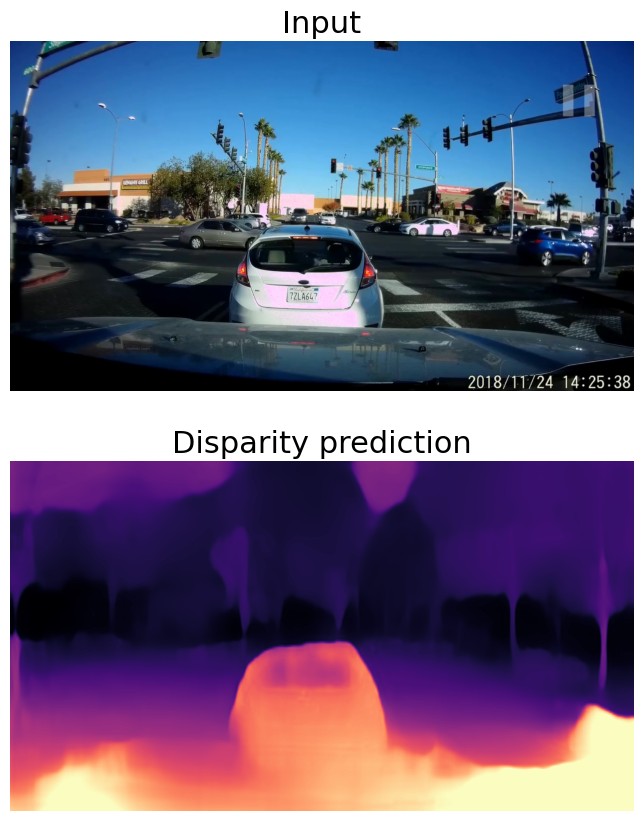

In [17]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)
print(disp_resized, torch.min(disp_resized), torch.max(disp_resized))
# Saving colormapped depth image
# from monodepth2.evaluate_depth import STEREO_SCALE_FACTOR
STEREO_SCALE_FACTOR = 5.4

disp_resized_np = STEREO_SCALE_FACTOR * disp_resized.squeeze().cpu().numpy()
print(disp_resized_np, np.min(disp_resized_np), np.max(disp_resized_np))
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');